In [2]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM

!apt-get install -y -qq libboost-all-dev

Cloning into 'LightGBM'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 17080 (delta 13), reused 2 (delta 0), pack-reused 17050
Receiving objects: 100% (17080/17080), 11.66 MiB | 0 bytes/s, done.
Resolving deltas: 100% (12437/12437), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/kaggle/working/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 0 bytes/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [3]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 6.3.0
-- The CXX compiler identification is GNU 6.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Try OpenMP C flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Try OpenMP CXX flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Found OpenMP: -fopenmp  
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking for CL_VERSION_

rm: cannot remove 'build': No such file or directory


In [4]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.t

In [5]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgbm

import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf


In [21]:
dataset = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows = 25000000)
dataset = dataset.dropna(how = 'any', axis = 'rows')

In [22]:
def clean_df(df):
    return df[(df.fare_amount > 2.5)  & (df.fare_amount <= 350) &
          (df.passenger_count > 0) & (df.passenger_count <= 6)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0))]

dataset = clean_df(dataset)
dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.432526e+07,2.432526e+07,2.432526e+07,2.432526e+07,2.432526e+07,2.432526e+07
mean,1.136284e+01,-7.391830e+01,4.069376e+01,-7.391422e+01,4.069067e+01,1.692416e+00
std,9.679806e+00,8.069376e+00,7.456048e+00,8.119182e+00,7.591743e+00,1.307827e+00
min,2.510000e+00,-3.439245e+03,-3.492264e+03,-3.442025e+03,-3.493652e+03,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073652e+01,-7.399159e+01,4.073553e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398060e+01,4.075384e+01,1.000000e+00
75%,1.250000e+01,-7.396831e+01,4.076754e+01,-7.396535e+01,4.076839e+01,2.000000e+00
max,3.500000e+02,3.457626e+03,3.406008e+03,3.457622e+03,3.390614e+03,6.000000e+00


In [23]:
#Training on range of latitude and longitude based on test data

def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])


BB = (-74.26, -72.98, 40.56, 41.70)

dataset = dataset[select_within_boundingbox(dataset, BB)]

In [24]:
def add_datetime_info(dataset):
    # Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    return dataset

In [25]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    # Define earth radius (km)
    R_earth = 6371
    
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                         [pickup_lat, pickup_lon, 
                                                          dropoff_lat, dropoff_lon])

    # Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    # Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))


def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    #Define earth radius (km)
    R_earth = 6371
    
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a


def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

def radian_conv(degree):
    return  np.radians(degree)

In [26]:
dataset = add_datetime_info(dataset)
dataset = add_airport_dist(dataset)
                                  
dataset['distance'] = sphere_dist(dataset['pickup_latitude'], dataset['pickup_longitude'], 
                                   dataset['dropoff_latitude'] , dataset['dropoff_longitude']) 

dataset['bearing'] = sphere_dist_bear(dataset['pickup_latitude'], dataset['pickup_longitude'], 
                                   dataset['dropoff_latitude'] , dataset['dropoff_longitude'])

dataset['pickup_latitude'] = radian_conv(dataset['pickup_latitude'])
dataset['pickup_longitude'] = radian_conv(dataset['pickup_longitude'])
dataset['dropoff_latitude'] = radian_conv(dataset['dropoff_latitude'])
dataset['dropoff_longitude'] = radian_conv(dataset['dropoff_longitude'])

In [27]:
dataset.drop(["pickup_datetime", "key"], axis = 1, inplace = True)

In [28]:
y = dataset['fare_amount']
train = dataset.drop(columns=['fare_amount'])

In [29]:
x_train, x_test, y_train, y_test = train_test_split(train, y, random_state = 123, test_size=0.10)

In [30]:
del dataset
del train
del y
import gc
gc.collect()

52

In [31]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.15,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 15,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
        
    }

train_set = lgbm.Dataset(x_train, y_train, silent=False, categorical_feature=['year','month','day'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False, categorical_feature=['year','month','day'])
del x_train, y_train, x_test, y_test
gc.collect()
model = lgbm.train(params, train_set = train_set, num_boost_round=10000, early_stopping_rounds=500, verbose_eval=500, valid_sets=valid_set)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  else:


Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.66408
[1000]	valid_0's rmse: 3.62244
[1500]	valid_0's rmse: 3.60508
[2000]	valid_0's rmse: 3.59224
[2500]	valid_0's rmse: 3.58304
[3000]	valid_0's rmse: 3.57736
[3500]	valid_0's rmse: 3.57184
[4000]	valid_0's rmse: 3.56762
[4500]	valid_0's rmse: 3.56522
[5000]	valid_0's rmse: 3.56296
[5500]	valid_0's rmse: 3.56121
[6000]	valid_0's rmse: 3.5591
[6500]	valid_0's rmse: 3.55828
[7000]	valid_0's rmse: 3.55731
[7500]	valid_0's rmse: 3.55568
[8000]	valid_0's rmse: 3.55458
[8500]	valid_0's rmse: 3.55411
[9000]	valid_0's rmse: 3.55344
[9500]	valid_0's rmse: 3.55261
[10000]	valid_0's rmse: 3.55235
[10500]	valid_0's rmse: 3.55155
[11000]	valid_0's rmse: 3.55113
[11500]	valid_0's rmse: 3.55107
Early stopping, best iteration is:
[11211]	valid_0's rmse: 3.55084


In [32]:
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')
test_df = add_datetime_info(test_df)
test_df = add_airport_dist(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['bearing_distance'] = sphere_dist_bear(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['pickup_latitude'] = radian_conv(test_df['pickup_latitude'])
test_df['pickup_longitude'] = radian_conv(test_df['pickup_longitude'])
test_df['dropoff_latitude'] = radian_conv(test_df['dropoff_latitude'])
test_df['dropoff_longitude'] = radian_conv(test_df['dropoff_longitude'])
                                                                    
test_key = test_df['key']
test_df = test_df.drop(columns=['key', 'pickup_datetime'])

#Predict from test set
prediction = model.predict(test_df, num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})
submission.to_csv("submission.csv", index = False)

In [33]:
submission

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.530334
1,2015-01-27 13:08:24.0000003,10.140592
2,2011-10-08 11:53:44.0000002,4.129869
3,2012-12-01 21:12:12.0000002,8.939422
4,2012-12-01 21:12:12.0000003,16.102389
...,...,...
9909,2015-05-10 12:37:51.0000002,9.077497
9910,2015-01-12 17:05:51.0000001,10.464704
9911,2015-04-19 20:44:15.0000001,55.709207
9912,2015-01-31 01:05:19.0000005,18.490874


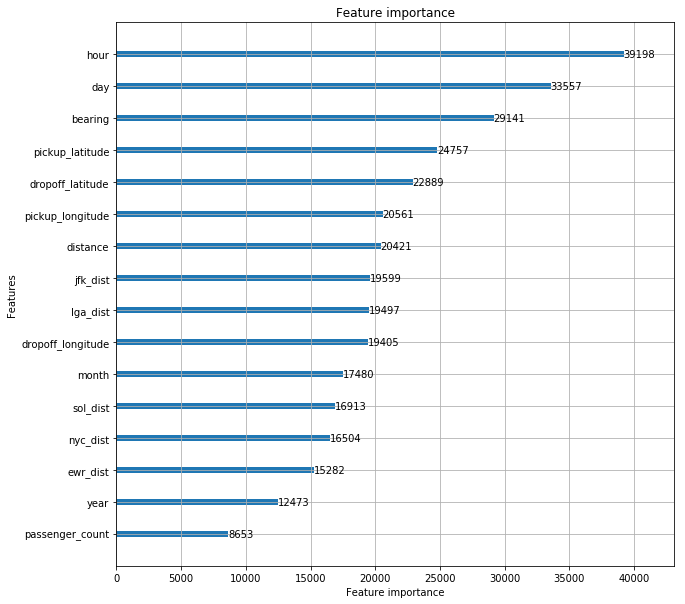

In [35]:
ax = lgbm.plot_importance(model, figsize=(10,10))
plt.show()